first round of investigation / playing around was done in "feature_engineering.ipynb"

I'll use this notebook to make things more clean and clear

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import re # for parsing with regex

In [4]:
df = pd.read_csv('../data/1200-1399/game.csv')
df.head(1)

,Event,Site,White,Black,WhiteElo,BlackElo,TimeControl,Date,ECO,PlyCount,Result,Movements
0,FICS rated standard game,FICS freechess.org,edclaudio,edinei,1370,1345,3600+30,2020.05.12,C41,165,1-0,1. e4 e5 2. Nf3 d6 3. h3 c6 4. Bc4 h6 5. Nc3 N...


the csv files have been created by reading through the raw pgn game file with a custom parsing script that I've built. "pgn_to_csv.py" in /src

In [9]:
''' first, I need to transform the "Movements" column into something more consumable '''

def parse_movements_to_player_moves(movement, side):
    # split the game into individual turns
    split = re.split('[0-9]+\.', movement)
    # strip white spaces and the last move
    moves = list(map(lambda v: v.strip(), split))
    last_move = moves[-1]
    moves = moves[1:-1]
    white_black_moves = list(map(lambda v: v.split(" "), moves))
    if side == 'White':
        return [move[0] for move in white_black_moves]
    else:
        return [move[1] for move in white_black_moves]

# create "Moves_White" to describe white's movement and "Moves_Black"
df['Moves_White'] = df['Movements'].transform(parse_movements_to_player_moves, side='White')
df['Moves_Black'] = df['Movements'].transform(parse_movements_to_player_moves, side='Black')

print("Moves_White", df['Moves_White'].head())
print("Moves_Black", df['Moves_Black'].head())

Moves_White 0    [e4, Nf3, h3, Bc4, Nc3, d3, Ne2, Bxe6, O-O, a3...
1    [d4, e3, c4, c5, Nc3, b4, Nf3, Nxb5, Nd6+, cxd...
2    [e4, Nf3, a3, Nc3, d3, Be2, O-O, e5, h3, Nxe5,...
3    [e4, Nc3, a3, Bc4, d3, Nge2, O-O, f4, Nxf4, Be...
4    [e4, d4, d5, a3, Nf3, Nc3, Be2, Bxf3, O-O, Re1...
Name: Moves_White, dtype: object
Moves_Black 0    [e5, d6, c6, h6, Nf6, Qe7, Be6, Qxe6, Nbd7, Be...
1    [d5, Nf6, e6, c6, b6, b5, a5, axb4, Bxd6, Qxd6...
2    [c5, Nc6, e6, Qb6, g6, Nf6, Bg7, Ng4, Ngxe5, N...
3    [e5, Nc6, d6, Nf6, Nd4, Be7, O-O, exf4, c5, Bg...
4    [e5, Nc6, Nb4, Na6, d6, Bg4, Bxf3, Nf6, Nc5, Q...
Name: Moves_Black, dtype: object


first, let's look at what pieces are moved most often

here are some notations

P: pawn
N: knight
B: bishop
R: rook
Q: queen
K: king

In [12]:
def getMoveCountForPiece(moves, piece):
    count = 0
    for move in moves:
        if piece == 'P':
            if move[0].islower(): # this is because pawn moves don't have a preceeding 'P'
                count += 1
        else:
            if move[0] == piece:
                count += 1
    return count

In [13]:
df['PawnMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='P')
df['KnightMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='N')
df['BishopMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='B')
df['RookMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='R')
df['QueenMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='Q')
df['KingMoveCount_White'] = df['Moves_White'].transform(getMoveCountForPiece, piece='K')

Text(0.5, 0, 'number of moves')

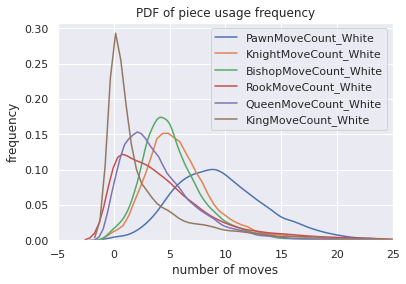

In [32]:
# let's do some univariate analysis on these features
sns.kdeplot(df['PawnMoveCount_White'])
sns.kdeplot(df['KnightMoveCount_White'])
sns.kdeplot(df['BishopMoveCount_White'])
sns.kdeplot(df['RookMoveCount_White'])
sns.kdeplot(df['QueenMoveCount_White'])
sns.kdeplot(df['KingMoveCount_White'])
plt.xlim(-5, 25)
plt.title('PDF of piece usage frequency')
plt.ylabel('frequency')
plt.xlabel('number of moves')

Text(0.5, 0, 'number of moves')

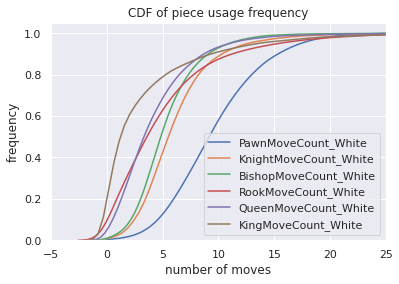

In [34]:
sns.kdeplot(df['PawnMoveCount_White'], cumulative=True)
sns.kdeplot(df['KnightMoveCount_White'], cumulative=True)
sns.kdeplot(df['BishopMoveCount_White'], cumulative=True)
sns.kdeplot(df['RookMoveCount_White'], cumulative=True)
sns.kdeplot(df['QueenMoveCount_White'], cumulative=True)
sns.kdeplot(df['KingMoveCount_White'], cumulative=True)
plt.xlim(-5, 25)
plt.title('CDF of piece usage frequency')
plt.ylabel('frequency')
plt.xlabel('number of moves')

Pawn seems to be the most used piece and King the least

P > K > B > Q = R > K

However, we should remember that there are more pawns than the elite pieces.
To be exact, 8 P, 2 N,B,R, 1 Q, 1 K.



Text(0.5, 0, 'number of moves (standardized by number of pieces)')

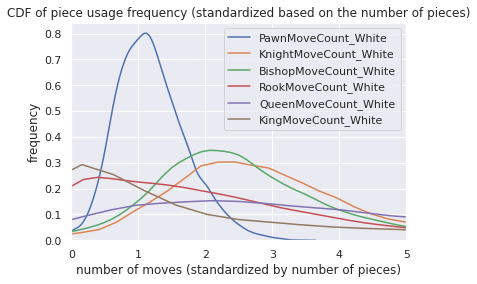

In [43]:
sns.kdeplot(df['PawnMoveCount_White']/8)
sns.kdeplot(df['KnightMoveCount_White']/2)
sns.kdeplot(df['BishopMoveCount_White']/2)
sns.kdeplot(df['RookMoveCount_White']/2)
sns.kdeplot(df['QueenMoveCount_White'])
sns.kdeplot(df['KingMoveCount_White'])
plt.xlim(0, 5)
plt.title('CDF of piece usage frequency (standardized based on the number of pieces)')
plt.ylabel('frequency')
plt.xlabel('number of moves (standardized by number of pieces)')

After standardizing the count, it looks like the Pawns are actually utilized the least.

This may be due to the fact that pawns are not allowed to move backward, which is why a player must think throughly before commiting a movement with a pawn.

The interesting fact we can extract from this graph is that Knights are more often used compared to Bishops, and Bishops are more used that Rooks. (K,B,R are 3 elite pieces apart from Queen and King).

It would be interesting to see which pieces are utilized more often through out the duration of the game.

(ex, is Knight used more often during the early game? if so, what is the reason?)

To carry out the early/mid/late game analysis, the boundaries need to be properly defined.

However, there are no strict rules that determine this idea so it is open to subjectivity.

As I watched many chess videos/tutorials, I noticed that they were talking about something called "chess openings". They often said "the opening is over" when  most of the center area was occupied with each player's pieces.

In terms of chess pieces, they generally said the opening is complete when

1. 2 pawns (in front of King and Queen) have moved
2. 2 Knights / 2 Bishops have moved

Thus in total this can be done in 6 moves, but I'll say the opening is 10 moves just to give some flexibility.

In [81]:
def getNumberOfPieceMovesForPhase(moves, piece, phase):
    count = 0

    # split based on the game phase
    if phase == 'Early':
        moves = moves[:10]
    if phase == 'Mid':
        moves = moves[10:20]
    if phase == 'Late':
        moves = moves[20:]

    for move in moves:
        if piece == 'P':
            if move[0].islower():
                count += 1
        else:
            if move[0] == piece:
                count += 1
    return count

In [82]:
df['PawnMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='P', phase='Early')
df['KnightMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='N', phase='Early')
df['BishopMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='B', phase='Early')
df['RookMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='R', phase='Early')
df['QueenMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='Q', phase='Early')
df['KingMoveCount_Early_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='K', phase='Early')

df['PawnMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='P', phase='Mid')
df['KnightMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='N', phase='Mid')
df['BishopMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='B', phase='Mid')
df['RookMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='R', phase='Mid')
df['QueenMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='Q', phase='Mid')
df['KingMoveCount_Mid_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='K', phase='Mid')

df['PawnMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='P', phase='Late')
df['KnightMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='N', phase='Late')
df['BishopMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='B', phase='Late')
df['RookMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='R', phase='Late')
df['QueenMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='Q', phase='Late')
df['KingMoveCount_Late_White'] = df['Moves_White'].transform(getNumberOfPieceMovesForPhase, piece='K', phase='Late')

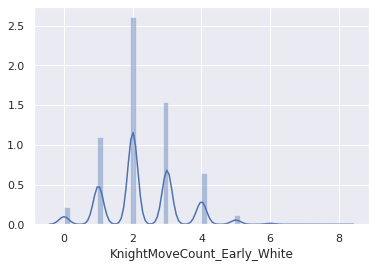

In [83]:
sns.distplot(df['KnightMoveCount_Early_White'])

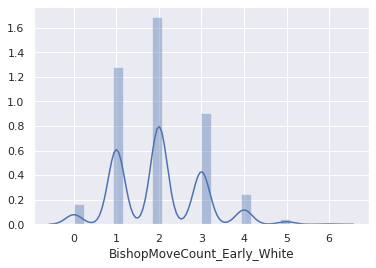

In [84]:
sns.distplot(df['BishopMoveCount_Early_White'])

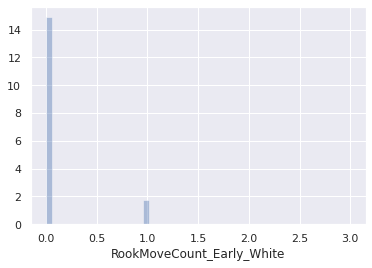

In [85]:
sns.distplot(df['RookMoveCount_Early_White'])

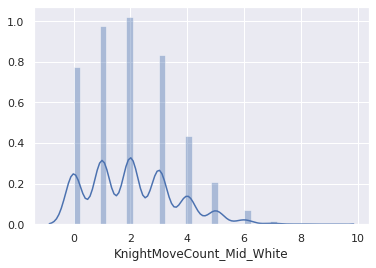

In [86]:
sns.distplot(df['KnightMoveCount_Mid_White'])

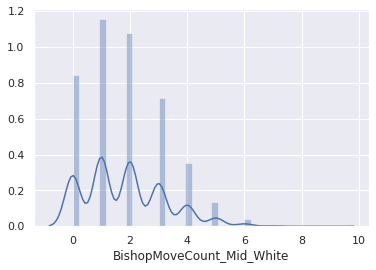

In [87]:
sns.distplot(df['BishopMoveCount_Mid_White'])

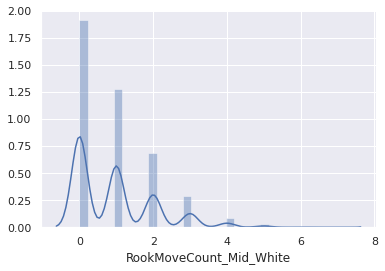

In [88]:
sns.distplot(df['RookMoveCount_Mid_White'])

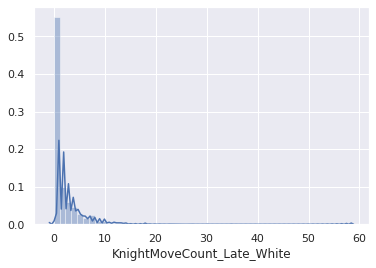

In [89]:
sns.distplot(df['KnightMoveCount_Late_White'])

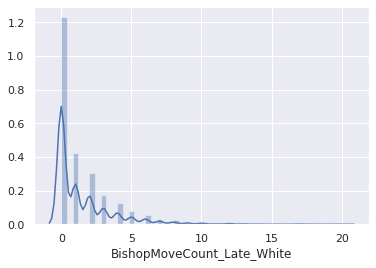

In [90]:
sns.distplot(df['BishopMoveCount_Late_White'])

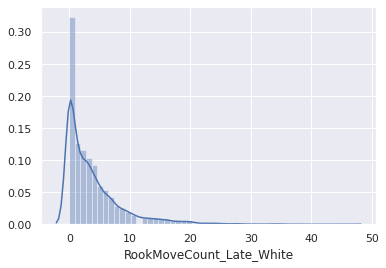

In [91]:
sns.distplot(df['RookMoveCount_Late_White'])